In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import pandas as pd
import numpy as np
from collections import defaultdict

# Some useful utilities

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon, size=len(v))

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

def z_clip(xs, b):
    return [min(x, b) for x in xs]

def g_clip(v):
    n = np.linalg.norm(v, ord=2)
    if n > 1:
        return v / n
    else:
        return v
    
X = np.load('adult_processed_x.npy')
y = np.load('adult_processed_y.npy')

training_size = int(X.shape[0] * 0.8)

X_train = X[:training_size]
X_test = X[training_size:]

y_train = y[:training_size]
y_test = y[training_size:]

y_test.shape

def predict(xi, theta, bias=0):
    label = np.sign(xi @ theta + bias)
    return label

# The loss function measures how good our model is. The training goal is to minimize the loss.
# This is the logistic loss function.
def loss(theta, xi, yi):
    exponent = - yi * (xi.dot(theta))
    return np.log(1 + np.exp(exponent))

# This is the gradient of the logistic loss
# The gradient is a vector that indicates the rate of change of the loss in each direction
def gradient(theta, xi, yi):
    exponent = yi * (xi.dot(theta))
    return - (yi*xi) / (1+np.exp(exponent))

def accuracy(theta):
    return np.sum(predict(X_test, theta) == y_test)/X_test.shape[0]

def avg_grad(theta, X, y):
    grads = [gradient(theta, xi, yi) for xi, yi in zip(X, y)]
    return np.mean(grads, axis=0)

def gradient_descent(iterations):
    # Start by "guessing" what the model should be (all zeros)
    theta = np.zeros(X_train.shape[1])

    # Perform `iterations` steps of gradient descent using training data
    for i in range(iterations):
        theta = theta - avg_grad(theta, X_train, y_train)

    return theta

def L2_clip(v, b):
    norm = np.linalg.norm(v, ord=2)
    
    if norm > b:
        return b * (v / norm)
    else:
        return v
    
def gradient_sum(theta, X, y, b):
    gradients = [gradient(theta, x_i, y_i) for x_i, y_i in zip(X,y)]
        
    # sum query
    # L2 sensitivity is b (by sensitivity of the gradient)
    return np.sum(gradients, axis=0)

def noisy_gradient_descent(iterations, epsilon, delta):
    theta = np.zeros(X_train.shape[1])
    sensitivity = 5.0
    
    noisy_count = laplace_mech(X_train.shape[0], 1, epsilon)
    clipped_X = [L2_clip(x_i, sensitivity) for x_i in X_train]

    for i in range(iterations):
        grad_sum        = gradient_sum(theta, clipped_X, y_train, sensitivity)
        noisy_grad_sum  = gaussian_mech_vec(grad_sum, sensitivity, epsilon, delta)
        noisy_avg_grad  = noisy_grad_sum / noisy_count
        theta           = theta - noisy_avg_grad

    return theta

# Efficiency

```{admonition} Learning Objectives
After reading this chapter, you will be able to:
- Design experiments to measure time and space overhead for private algorithms
- Consider tradeoffs between space and time efficiency
- Consider techniques for optimization
- Describe the efficiency bottlenecks in differentially private algorithms
```

## Time Efficiency of Differential Privacy

In a situation where the application of differential privacy is implemented as a direct loop over sensitive entities, there is a significant time cost incurred from the added burden of random number generation.

We can contrast the runtime performance of two versions of a counting query - one with differential privacy, and one without it.

In [19]:
import itertools
import operator
import time

def time_count(k):   
    l = [1] * k
    start = time.perf_counter()
    _ = list(itertools.accumulate(l, func=operator.add))
    stop = time.perf_counter()
    return stop - start 

def time_priv_count(k):  
    l = [1] * k
    start = time.perf_counter()
    _ = list(itertools.accumulate(l, func=lambda x, y: x + laplace_mech(y,1,0.1), initial=0))
    stop = time.perf_counter()
    return stop - start 

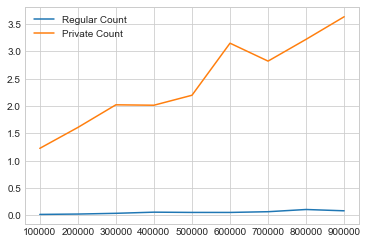

In [20]:
x_axis = [k for k in range(100_000,1_000_000,100_000)]
plt.plot(x_axis, [time_count(k) for k in range(100_000,1_000_000,100_000)], label='Regular Count')
plt.plot(x_axis, [time_priv_count(k) for k in range(100_000,1_000_000,100_000)], label='Private Count')
plt.legend();

With the time spent counting on the y-axis, and the list lize on the x-axis, we can see that the time complexity of differential privacy for this particular operation is essentially linear in the size of the input.

The good news is that the above implementation of differentially private count is rather naive, and we can do much better using optimization techniques such as vectorization!

For example, when implementing differential privacy for the machine learning operations in [a previous](https://programming-dp.com/ch12.html) chapter, we make use of NumPy functions which are heavily optimized for vector-based operations. In this particular scenario, leveraging this strategy, we manage to incur negligible time cost for the use of differential privacy.

In [21]:
delta = 1e-5

def time_gd(k):   
    start = time.perf_counter()
    gradient_descent(k)
    stop = time.perf_counter()
    return stop - start 

def time_priv_gd(k):   
    start = time.perf_counter()
    noisy_gradient_descent(k, 0.1, delta)
    stop = time.perf_counter()
    return stop - start 


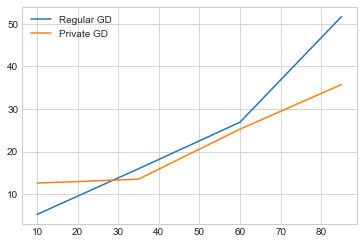

In [22]:
x_axis = [k for k in range(10,100,25)]
plt.plot(x_axis, [time_gd(k) for k in range(10,100,25)], label='Regular GD')
plt.plot(x_axis, [time_priv_gd(k) for k in range(10,100,25)], label='Private GD')
plt.legend();

The graph plots generally overlap or are close in most simulations of this experiment, indicating low (constant) time inefficiency overhead incurred from utilizing private gradient descent.

## Space Cost of Differential Privacy

We can also analyze the space utilization of differential privacy mechanisms. Python3 (3.4) introduces a [debug tool](https://docs.python.org/3/library/tracemalloc.html) capable of tracing memory blocks allocated for use during evaluation. We may perform our analysis of space overhead by comparing the peak size of memory blocks used during private versus non-private computation.

Using this strategy, we can analyze the space overhead of the private count operation as follows:


In [23]:
import itertools
import operator
import tracemalloc

def space_count(k):   
    l = [1] * k
    itertools.accumulate(l, func=operator.add)
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.reset_peak()
    return peak/1000 

def space_priv_count(k):  
    l = [1] * k
    itertools.accumulate(l, func=lambda x, y: x + laplace_mech(y,1,0.1), initial=0)
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.reset_peak()
    return peak/1000


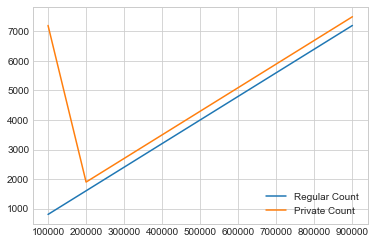

In [24]:
tracemalloc.start()
x_axis = [k for k in range(100_000,1_000_000,100_000)]
plt.plot(x_axis, [space_count(k) for k in range(100_000,1_000_000,100_000)], label='Regular Count')
plt.plot(x_axis, [space_priv_count(k) for k in range(100_000,1_000_000,100_000)], label='Private Count')
tracemalloc.stop()
plt.legend();

We display every thousand memory blocks on the y-axis, against the list size on the x-axis. 

In this case, the memory complexity of differential privacy is generally constant.

We also observe a spike in the initial space cost for private count, which we can attribute to memory allocation for setup of the random number generator resources such as the entropy pool and PRNG (pseudo-random number generator).

We can repeat this experiment to contrast private and non-private machine learning:

In [25]:
def space_gd(k):   
    gradient_descent(k)
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.reset_peak()
    return peak/1_000_000 

def space_priv_gd(k):   
    noisy_gradient_descent(k, 0.1, delta)
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.reset_peak()
    return peak/1_000_000


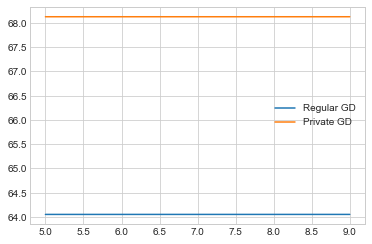

In [26]:
tracemalloc.start()
x_axis = [k for k in range(5,10,2)]
plt.plot(x_axis, [space_gd(k) for k in range(5,10,2)], label='Regular GD')
plt.plot(x_axis, [space_priv_gd(k) for k in range(5,10,2)], label='Private GD')
tracemalloc.stop()
plt.legend();

In this case, since we are performing gradient descent, the memory allocation is generally much larger - as expected - so we graph against every millionth allocated memory block. 

We also observe generally constant space overhead during private gradient descent. However the space overhead is much larger here since we leverage extra space for vectorization and concurrency to improve time efficiency.

## Limitations of Random Number Generation 

In conclusion, while some bottlenecks may exist, there are techniques we can use to keep both the space and time cost of differential privacy generally low (constant) throughout the lifetime of program evaluation.

Why do any bottlenecks exist, and why are they particular to differential privacy? In order to preserve the guarantee of differential privacy, we require high-quality entropy. This is a limited resource because it generally relies on some external source of non-deterministic environmental input. Examples of non-determinintic entropy sources can include disk/network IO, keyboard presses, and mouse movement.

Usually this entropy is stored in some special [buffer or file](https://en.wikipedia.org/wiki//dev/random) to be retrieved and used later on.

In [27]:
with open("/dev/random", 'rb') as file:
    print(file.read(8))

b'\xbe\xfc\x9b\xd9.d\xb7\xca'


Alternatively, we could use:

In [28]:
import os
os.urandom(32)

b'\xc7G\xa0\xf7.]\xaf\xe60\xfd6![ \x9a\x8f\xcfa=\xc0`mt\xcfguE\xe8\x92^G\xe9'

Or:

In [17]:
import secrets 
secrets.token_bytes(32)

b"t\xfb\xbfi\x10U\xca\x13\xce\x1f\xf9|\x9b\xd6\x0f\xce+\x89*\x9aR\x0e_\x0e\x1b\x9d'DcOT7"

In general, in different programming languages and operating systems, there are several options for random number and seed generation, with varying applicability for use cases such as: modeling, simulation, or production of cryptographically strong random bytes suitable for managing sensitive user data at scale.